In [40]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 

import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error #=mean error (Simon 2012)
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from scipy.optimize import minimize

from scipy.spatial import distance
from sklearn.metrics.pairwise import nan_euclidean_distances

from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
from sklearn.preprocessing import PowerTransformer

import sys
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [3]:
def initialize(threshold, start_time):
#     PM25 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/PM25")
    PM25 = pd.read_pickle("~/Documents/saved_data_from_notebooks/PM25") #Lab's computer

    times = pd.date_range(start=start_time, end='2018-12-31 23:00:00', freq='30Min') #one less because the last is always nan

    start_idx = PM25.shape[0]-times.shape[0]

    # remove the last index as it is always nan
    PM25 = PM25[:-1]
    times = times[:-1]

    # reduced PM25 
    r_PM25 = PM25[start_idx:] 
    idx = r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]>threshold
    r_PM25 = r_PM25.loc[:, idx]

    r_PM25.reset_index(inplace=True)
    r_PM25.drop(labels = 'index',axis=1, inplace=True)
    
    return times, r_PM25

In [4]:
# create a np_array np_y_missing, fill the np_y_missing with values where the validation
# indexes are chosen. 
# randomly choose chunks of certain size
def get_validation_index(PM25, interval_length, s, how_many, total_excude):    
    
    # find all valid indexes
    pot_idx = np.argwhere((PM25.iloc[:,s].notnull().rolling(interval_length,min_periods=0).sum()>(interval_length-interval_length/100)).values).ravel()
    # in case the last index is at the end
    if (pot_idx[-1] == PM25.shape[0]-1):
        pot_idx=pot_idx[:-1]
        
    chosen_idx = pot_idx[(~np.isnan(PM25.iloc[pot_idx-interval_length,s].values)) & (~np.isnan(PM25.iloc[pot_idx+1,s].values)) & (pot_idx>=interval_length)]
    # exclude places I already took for validation of that station
    # make sure chosen_idx is non in these places or 
    chosen_idx=[x for x in chosen_idx if ((not total_excude[x]) and (not total_excude[x-interval_length]))]

    # randomly choose it
    chosen = np.random.choice(chosen_idx,how_many,replace=False)+1

    return (chosen-interval_length,chosen)

In [5]:
# a function that returns X_missing, y_missing (splits the data according to Interval Length(IL))
def return_X_y(PM25,IL):
 
    X_missing = PM25.copy()
    y_missing = PM25.copy() 

    np_r_PM25_y_mask = PM25.copy().values
    np_r_PM25_y_mask[:] = 0
    
    for s in tqdm(range(np_r_PM25_y_mask.shape[1])):
        
        total_excude = np.zeros(np_r_PM25_y_mask.shape[0])
        for j in range(len(IL)):
        
            interval_length = int(IL[j]*2)
            how_many = int(720/IL[j])
            A,B = get_validation_index(PM25, interval_length, s, how_many, total_excude)
            for a,b in zip(A,B):
                total_excude[a:b] = 1
                np_r_PM25_y_mask[a:b,s] = -(j+1)  

    # ITERATE HERE AGAIN FOR j TIMES, TO GET FOR EACH
    # COLUMN j GROUPS OF DESIRED INTERVAL LENGTH FOR EVALUATION.
    # (maybe -1 to -j...)        
                      
    # y_missing 
    y_missing.iloc[:] = np.nan
    np_y_missing = y_missing.values
    np_X_missing = X_missing.values

    # put in np_y_missing 
    np_X_missing_copy = np_X_missing.copy()
    
    for j in range(len(IL)):
        np_y_missing[np_r_PM25_y_mask==-(j+1)]=np_X_missing_copy[np_r_PM25_y_mask==-(j+1)]
        # X_missing
        np_X_missing[np_r_PM25_y_mask==-(j+1)]=np.nan
    
    return np_X_missing, np_y_missing, np_r_PM25_y_mask

In [6]:
# a function that returns X_missing, y_missing that are randomly spread
# (instead of chunks. just for comparison)
def return_randomly_spread_X_y(PM25,IL):
 
    X_missing = PM25.copy()
    y_missing = PM25.copy() 
    
    np_PM25 = PM25.values
    
    not_nan_idx = np.argwhere(PM25.notnull().values)    
    test_index = np.random.choice(not_nan_idx.shape[0],IL)
        
    # y_missing 
    y_missing.iloc[:] = np.nan
    np_y_missing = y_missing.values

    # asssign values according to test indexes
    rows, cols = zip(*not_nan_idx[test_index])
    vals = np_PM25[rows, cols]
    np_y_missing[rows, cols] = vals

    # X_missing
    # assign nans according to test indexes
    np_X_missing = X_missing.values
    np_X_missing[rows, cols] = np.nan

    return np_X_missing, np_y_missing

In [7]:
# a function that imputes for each of the methods

def impute_ii_BR(np_X_missing, num_iter):
    imp = IterativeImputer(max_iter=num_iter,estimator=BayesianRidge(),verbose=True) 
    imp.fit(np_X_missing)
    imputed = imp.transform(np_X_missing) 
    return imputed

def impute_ii_RF(np_X_missing, num_iter, rnd_state_forRF, params):
#     n_jobs=-1 # add to ExtraTreesRegressor if I want all cores. 
    if params['max_depth'] is None:
        md = None
    else:
        md = int(params['max_depth'])
    imp = IterativeImputer(max_iter=num_iter,
                           estimator=ExtraTreesRegressor(n_estimators=int(params['n_estimators']),
                                                         bootstrap=params['bootstrap'],
                                                         max_depth=md, 
                                                         max_features=params['max_features'],
                                                         min_samples_leaf=int(params['min_samples_leaf']),
                                                         min_samples_split=int(params['min_samples_split']),
                                                         random_state=rnd_state_forRF,
                                                         n_jobs=-1
                                                        ),
                           verbose=True) 
    imp.fit(np_X_missing)
    imputed = imp.transform(np_X_missing)  
    return imputed

def impute_ii_KNN(np_X_missing, num_iter, num_neighbors, weight_type): #'uniform','distance'
#     n_jobs=-1 # add to KNeighborsRegressor if I want all cores. 
    imp = IterativeImputer(max_iter=num_iter,estimator=KNeighborsRegressor(n_neighbors=num_neighbors,weights=weight_type,n_jobs=-1),verbose=True) 
    imp.fit(np_X_missing)
    imputed = imp.transform(np_X_missing)     
    return imputed

def impute_my_KNN(np_X_missing, k):

    imputed = np_X_missing.copy() 
    all_data_mask_nans = imputed.copy()
    mask_nans = np.isnan(imputed)
    all_data_mask_nans[mask_nans]=0

    batch_size = 300
    not_nan_mask = 1-np.isnan(np_X_missing).astype(int)
    # all_data_norm = all_data_mask_nans / np.linalg.norm(all_data_mask_nans,axis=1)[:,np.newaxis] # normalize BY norm
    all_data_norm = np_X_missing / np.nanstd(np_X_missing, axis=0) # normalize BY norm 


    np_corrMatrix = pd.DataFrame(imputed).corr().values
    
    for cind in tqdm(range(np_X_missing.shape[1])): #tqdm(range(np_X_missing.shape[1]-33)) #range(34,int(np_X_missing.shape[1]/3)+1) #+1=AFULA, +34=all 
        nan_column_mask = np.isnan(np_X_missing[:,cind])
        not_nan_column_mask = np.logical_not(nan_column_mask)

        not_nan_in_colom_all_data_norm = all_data_norm[not_nan_column_mask, :]*np_corrMatrix[:,cind]

        not_nan_not_nan_mask = not_nan_mask[not_nan_column_mask, :] #relevant rows for this column (not nan)

        not_nan_column = np_X_missing[not_nan_column_mask,cind]    
        nan_ind = np.argwhere(nan_column_mask)
        
        for i in tqdm(range(0, len(nan_ind), batch_size), leave=False):
            rinds = np.ravel(nan_ind[i:i+batch_size])
            batch = all_data_norm[rinds, :]*np_corrMatrix[:,cind]

            batch_non_nan_mask = not_nan_mask[rinds, :]
            counts = np.dot(not_nan_not_nan_mask, batch_non_nan_mask.T)

            dists = nan_euclidean_distances(not_nan_in_colom_all_data_norm, batch)

            weights = counts/dists
            min_thr = np.partition(weights,-(k+1),axis=0)[-(k+1),:]
            weights = weights-min_thr
            # !If all the coordinates are missing or if there are no common present coordinates then NaN is returned in dists for that pair!
            weights[(weights<0) | (np.isnan(weights))] = 0
            weights = weights / weights.sum(axis=0)

            values = np.dot(weights.T, not_nan_column)
            imputed[rinds, cind] = values
            
    return imputed
    

In [9]:
# results = []

# for j in range(len(IL)):
#     y_train = np_y_missing[(~np.isnan(np_y_missing)) & (np_r_PM25_y_mask==-(j+1))]
#     y_pred = imputed[(~np.isnan(np_y_missing)) & (np_r_PM25_y_mask==-(j+1))]           

#     # assign results
#     RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
#     MedianAE = median_absolute_error(y_train, y_pred)
#     MeanAE = mean_absolute_error(y_train,y_pred)
#     R2 = r2_score(y_train,y_pred)
#     MeanBias = np.mean(y_pred - y_train) #if positive, we overestimate, if negative we underestimate
#     MedianBias = np.median(y_pred - y_train) #if positive, we overestimate, if negative we underestimate
#     NMB = np.sum(y_pred - y_train)/(np.sum(y_train))# Normalized mean bias
#     NME = np.sum(np.abs(y_pred - y_train))/(np.sum(y_train))# Normalized mean error

#     results.append([IL[j],RMSE,MedianAE,MeanAE,R2,MeanBias,MedianBias,NMB,NME])


In [10]:
# a function that cumputes validation results

def validate(imputed, np_y_missing, np_r_PM25_y_mask, IL):
                           
    all_y_train = np_y_missing[~np.isnan(np_y_missing)]
    all_y_pred = imputed[~np.isnan(np_y_missing)]
    
#     if np.isnan(y_pred).sum():
#         y_train = y_train[~np.isnan(y_pred)]
#         y_pred = y_pred[~np.isnan(y_pred)]
#         print('nan values detected in imputed matrix')
    results = []
      
    # assign results
    RMSE = np.sqrt(mean_squared_error(all_y_train, all_y_pred))
    MedianAE = median_absolute_error(all_y_train, all_y_pred)
    MeanAE = mean_absolute_error(all_y_train,all_y_pred)
    R2 = r2_score(all_y_train,all_y_pred)
    MeanBias = np.mean(all_y_pred - all_y_train) #if positive, we overestimate, if negative we underestimate
    MedianBias = np.median(all_y_pred - all_y_train) #if positive, we overestimate, if negative we underestimate
    NMB = np.sum(all_y_pred - all_y_train)/(np.sum(all_y_train))# Normalized mean bias
    NME = np.sum(np.abs(all_y_pred - all_y_train))/(np.sum(all_y_train))# Normalized mean error

    results.append(['ALL',RMSE,MedianAE,MeanAE,R2,MeanBias,MedianBias,NMB,NME])
         
    for j in range(len(IL)):
        y_train = np_y_missing[(~np.isnan(np_y_missing)) & (np_r_PM25_y_mask==-(j+1))]
        y_pred = imputed[(~np.isnan(np_y_missing)) & (np_r_PM25_y_mask==-(j+1))]           
             
        # assign results
        RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
        MedianAE = median_absolute_error(y_train, y_pred)
        MeanAE = mean_absolute_error(y_train,y_pred)
        R2 = r2_score(y_train,y_pred)
        MeanBias = np.mean(y_pred - y_train) #if positive, we overestimate, if negative we underestimate
        MedianBias = np.median(y_pred - y_train) #if positive, we overestimate, if negative we underestimate
        NMB = np.sum(y_pred - y_train)/(np.sum(y_train))# Normalized mean bias
        NME = np.sum(np.abs(y_pred - y_train))/(np.sum(y_train))# Normalized mean error

        results.append([IL[j],RMSE,MedianAE,MeanAE,R2,MeanBias,MedianBias,NMB,NME])
       
    results = pd.DataFrame(results, columns=['IL','RMSE','MedianAE','MeanAE','R2','MeanBias','MedianBias','NMB','NME'])   
    return results



def simple_validation(imputed, np_y_missing):
    y_train = np_y_missing[~np.isnan(np_y_missing)]
    y_pred = imputed[~np.isnan(np_y_missing)]
    
    if np.isnan(y_pred).sum():
        y_train = y_train[~np.isnan(y_pred)]
        y_pred = y_pred[~np.isnan(y_pred)]
        print('nan values detected in imputed matrix')
      
    # assign results
    RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
    MedianAE = median_absolute_error(y_train, y_pred)
    MeanAE = mean_absolute_error(y_train,y_pred)
    R2 = r2_score(y_train,y_pred)
    MeanBias = np.mean(y_pred - y_train) #if positive, we overestimate, if negative we underestimate
    MedianBias = np.median(y_pred - y_train) #if positive, we overestimate, if negative we underestimate
    NMB = np.sum(y_pred - y_train)/(np.sum(y_train))# Normalized mean bias
    NME = np.sum(np.abs(y_pred - y_train))/(np.sum(y_train))# Normalized mean error

    results = [RMSE,MedianAE,MeanAE,R2,MeanBias,MedianBias,NMB,NME]
    
    return results


In [11]:
def plot_hist(PM25, imputed, np_X_missing, density,no_bins,option):
#     # option-1
    if option=='1':
        plt.hist([PM25[~np.isnan(PM25)], np_X_missing[~np.isnan(np_X_missing)], imputed[np.isnan(np_X_missing)]],bins=1000,label=['original PM25','original X','imputed'],density=True)
    if option=='2':
        plt.hist(PM25[~np.isnan(PM25)],bins=no_bins,label=['original PM25'],alpha=0.3,density=density) #,edgecolor="k"
        plt.hist(np_X_missing[~np.isnan(np_X_missing)],bins=no_bins,label=['original X'],alpha=0.3,density=density)
        plt.hist(imputed[np.isnan(np_X_missing)],bins=no_bins,label=['imputed'],alpha=0.3,density=density)
    plt.xlim([-20,100])
    plt.legend()
    plt.show();

In [12]:
# a function for box plots for results


In [13]:
# statistics functions
def get_nan_lengths(PM25,nanLengths):
    
    if nanLengths:
        PM25[PM25.notnull()] = 1
        PM25[PM25.isnull()] = 0
    else:
        PM25[PM25.notnull()] = 0
        PM25[PM25.isnull()] = 1
        
    diffs = PM25.diff(axis = 0)

    missing_interval_lengths = []

    for monitor in range(PM25.shape[1]):

        #begining
        if PM25.iloc[0,monitor]==0:
            diffs.iloc[0,monitor]=-1

        #end
        if PM25.iloc[-1,monitor]==0:
            diffs.iloc[-1,monitor]=1

        row_start = np.where(diffs.iloc[:,monitor] == -1)[0]
        row_end = np.where(diffs.iloc[:,monitor] == 1)[0]

        xranges = list(list(zip(row_start,row_end-row_start)))
        missing_interval_lengths.extend(row_end-row_start)

    return missing_interval_lengths


def plot_nan_lengths_dist(missing_interval_lengths):
     
    data = [i*30/60 for i in missing_interval_lengths]#in hours
    _, bins = np.histogram(np.log10(data), bins='auto')

    # bins are unequal in width in a way that would make them look equal on a logarithmic scale.
    # matplotlib histogram
    plt.hist(data, color = 'blue',bins=10**bins)
    plt.gca().set_xscale("log")

    plt.title('distribution of length of \nmissing data intervals, by count')
    plt.xlabel('Interval length [hours]')
    plt.ylabel('Percentage [%]\n')
    plt.yticks(ticks=np.arange(0,len(missing_interval_lengths),np.floor(len(missing_interval_lengths)/10)),labels=np.round(100*np.arange(0,len(missing_interval_lengths),np.floor(len(missing_interval_lengths)/10))/len(data),1))
    
    # plt.ylim(0,1000)
    # plt.xlim(0,100)
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14})

    plt.show();
    
def plot_nan_lengths_cum_dist(missing_interval_lengths):    
    # pd.Series(missing_interval_lengths).hist(weights=missing_interval_lengths, bins=100, cumulative=True)
    a,b = np.histogram(missing_interval_lengths,weights=missing_interval_lengths, bins=np.max(missing_interval_lengths))
    plt.plot(a.cumsum()/np.sum(a));
    plt.plot(np.ones(np.max(missing_interval_lengths))*0.5,'r');


### initialize

In [64]:
threshold = 0.6 # how much non-missing values are in the time-series in order to include the station?
start_time = '2013-01-01 00:00:00'
times, r_PM25 = initialize(threshold, start_time)

In [67]:
# times_df = pd.DataFrame(times)
# times_df.to_csv("~/Documents/saved_data_from_notebooks/times_df.csv")

# (0) compare with other methods

https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

In [ ]:
# fast KNN (with KDE)

In [ ]:
# sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
imputed_training=fast_knn(r_PM25.values, k=10)

In [ ]:
# MICE

In [ ]:
imputed_training=mice(r_PM25.values)

# (1) model selection by 3-fold CV (hyperparameter tunning)

In [ ]:

# first find optimal parameters with only 1 iteration, then optimize for number of iterations. 
# Possibly - the number of iterations are related to the data of validation... so not sure I 
# could find something

In [ ]:
# hyperParams
# RF - number of trees (probably the more the better)
# KNN - number of neighbors, distance method 
# myKNN - number of neighbors

# in IterativeImputer - the method of initial imputation - mean/median...

In [ ]:
# CV is needed here to ensure that the decision is done after seeing the whole data. 
# "Under cross validation, each point gets tested exactly once, which seems fair. 
# However, cross-validation only explores a few of the possible ways that your data 
# could have been partitioned. Monte Carlo cross validation can give you a less variable, 
# but more biased estimate"
# https://stats.stackexchange.com/questions/51416/k-fold-vs-monte-carlo-cross-validation

##### Hyperparameters

In [255]:
rnd_state_forCV = 0
rnd_state_forRF = 0

#### GridSearchCV manually

In [318]:
# random forest
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

num_trees = np.arange(10,220,30) #[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
min_samples_split = np.arange(2,52,10) #[2, 5, 10] - maybe do a finer resolution
max_features = ['auto', 'sqrt', 'log2']

# # possibly add-
# max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
# bootstrap = [True, False]
# min_samples_leaf = [1, 2, 4]
# Hyperparameters of RF 
# # Number of trees in random forest
# n_estimators = [int(x) for x in range(10,420,30)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt', 'log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# # max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

len(num_trees)*len(min_samples_split)*len(max_features)

# knn
knn_k = np.arange(1,21)
weight_type = ['uniform','distance']
len(knn_k)*len(weight_type)

105

40

In [505]:
def cv_Kfolds(PM25,k):
    
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    
    for k, (train_index, test_index) in enumerate(kf.split(not_nan_idx)):
        
        # (1) split to X and y       
        np_PM25 = PM25.values
        X_missing = PM25.copy()
        y_missing = PM25.copy()

        # y_missing 
        y_missing.iloc[:] = np.nan
        np_y_missing = y_missing.values

        # asssign values according to test indexes
        rows, cols = zip(*not_nan_idx[test_index])
        vals = np_PM25[rows, cols]
        np_y_missing[rows, cols] = vals
        # turn back to dataframe
#         y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

        # X_missing
        # assign nans according to test indexes
        np_X_missing = X_missing.values
        np_X_missing[rows, cols] = np.nan
        
        # (2) fit all possible models
        num_iter = 1
        #### IterativeImputer Random Forest ####
        results_RF_cv = []
        cnt = 0
        for nt in num_trees:
            for mss in min_samples_split:
                for mf in max_features:
                    # impute
                  
                    # !!!! notice I changed impute_ii_RF!!!!
                    
                    imputed = impute_ii_RF(np_X_missing, num_iter, int(nt), rnd_state_forRF, int(mss), mf)
                    # validate
                    print(imputed.shape(), np_y_missing.shape())
                    temp = simple_validation(imputed, np_y_missing)
                    temp.extend([nt,mss,mf])
                    cnt+=1
                    print(cnt)
                    print(temp)
                    results_RF_cv.append(temp)
     
        # (3) save results
        results_RF_cv = pd.DataFrame(results_RF_cv, columns=['RMSE','MedianAE','MeanAE','R2','MeanBias','MedianBias','NMB','NME','num_trees','min_samples_split','max_features'])   
        results_RF_cv.to_pickle("~/Documents/saved_data_from_notebooks/results_RF_cv_"+str(k))


In [316]:
cv_Kfolds(r_PM25,k=3)

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 9189.18577396376, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
1
[10.73398108136534, 4.330000000000002, 6.171498820585852, 0.7901811157796121, 0.11891455114639846, 0.6400000000000006, 0.005998635035860753, 0.3113207651380085, 10, 2, 'auto']
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 8929.511067470366, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
2
[11.053118578242012, 4.399999999999999, 6.255209460373274, 0.7775191779575733, 0.01935769662206241, 0.6699999999999946, 0.0009764974601611976, 0.3155435416768102, 10, 2, 'sqrt']
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 8929.511067470366, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
3
[11.053118578242012, 4.399999999999999, 6.255209460373274, 

#### RandomSearchCV not suitable, use instead Hyperopt

In [319]:
# https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
# http://hyperopt.github.io/hyperopt/

In [649]:
from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt import tpe
from hyperopt import pyll
from hyperopt import Trials
from hyperopt import fmin

In [676]:
N_FOLDS = 3
num_iter = 1
PM25 = r_PM25.copy()
not_nan_idx = np.argwhere(r_PM25.notnull().values)
rnd_state_forRF = 0

In [677]:
def objective(params, n_folds = N_FOLDS, num_iter=num_iter):
    
    # Perform n_fold cross validation with hyperparameters
    # Evaluate based on RMSE?
    
    kf = KFold(n_splits=n_folds, shuffle=True)
  
    total_loss = []
    for k, (train_index, test_index) in enumerate(kf.split(not_nan_idx)):
        
        X_missing = PM25.copy()
        y_missing = PM25.copy()
        np_PM25 = PM25.values
        
        # y_missing 
        y_missing.iloc[:] = np.nan
        np_y_missing = y_missing.values

        # asssign values according to test indexes
        rows, cols = zip(*not_nan_idx[test_index])
        vals = np_PM25[rows, cols]
        np_y_missing[rows, cols] = vals

        # X_missing
        # assign nans according to test indexes
        np_X_missing = X_missing.values
        np_X_missing[rows, cols] = np.nan
       
        # impute
        imputed = impute_ii_RF(np_X_missing, num_iter, rnd_state_forRF, params)
        # validate
        
        print(params)
        print(np.shape(imputed))
        #!!!take only RMSE!!!
        loss = simple_validation(imputed, np_y_missing)[0]
        total_loss.append(loss)

    # Dictionary with information for evaluation
    return {'loss': np.mean(total_loss), 'params': params, 'status': STATUS_OK}

In [678]:
# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators',10,420,30),# Discrete uniform distribution
    'max_features': hp.choice('max_features',['auto', 'sqrt', 'log2']),
    'max_depth': hp.choice('max_depth',[None, hp.quniform('max_depth_quniform',10,110,10)]),# this gives 50% to None... should change it somehow
    'min_samples_split': hp.quniform('min_samples_split', 2,12,2),
    'min_samples_leaf': hp.quniform('min_samples_leaf',1,4,1),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

In [679]:
# Sample from the full space
params = pyll.stochastic.sample(space)
params

{'bootstrap': True,
 'max_depth': 70.0,
 'max_features': 'auto',
 'min_samples_leaf': 2.0,
 'min_samples_split': 8.0,
 'n_estimators': 240.0}

In [680]:
params['bootstrap']
params['max_depth']
params['max_features']
params['min_samples_leaf']
params['min_samples_split']
params['n_estimators']

True

70.0

'auto'

2.0

8.0

240.0

In [681]:
tpe_algorithm = tpe.suggest

In [682]:
# Trials object to track progress
bayes_trials = Trials()

In [683]:
params

{'bootstrap': True,
 'max_depth': 70.0,
 'max_features': 'auto',
 'min_samples_leaf': 2.0,
 'min_samples_split': 8.0,
 'n_estimators': 240.0}

In [673]:
# imputed = impute_ii_RF(np_X_missing, num_iter, rnd_state_forRF, params)

In [674]:
# imputed
# loss = simple_validation(imputed, np_y_missing)[0]

In [684]:
MAX_EVALS = 5

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials)

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 8545.894945294689, scaled tolerance: 1.4641 
[IterativeImputer] Completing matrix with shape (105166, 34)
{'bootstrap': True, 'max_depth': 50.0, 'max_features': 'log2', 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 240.0}
(105166, 34)                                         
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 8203.481532141492, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
{'bootstrap': True, 'max_depth': 50.0, 'max_features': 'log2', 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 240.0}
(105166, 34)                                         
[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 7959.21318423682, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)
{'bootstrap': True, 'max_depth': 50.0

In [686]:
best

{'bootstrap': 0,
 'max_depth': 1,
 'max_depth_quniform': 50.0,
 'max_features': 2,
 'min_samples_leaf': 2.0,
 'min_samples_split': 6.0,
 'n_estimators': 240.0}

In [ ]:
   
#     #### IterativeImputer KNN ####

#     weight_type = 'distance' #'uniform','distance' #hyperParam
#     num_neighbors = 10 #hyperParam
#     # impute
#     imputed = impute_ii_KNN(np_X_missing, num_iter, num_neighbors, weight_type)
#     # validate
#     results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)
#     # save 
#     imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
#     imputed_df.to_pickle("~/Documents/saved_data_from_notebooks/imputed_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
#     results.to_pickle("~/Documents/saved_data_from_notebooks/results_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
#     print(results)
    


In [ ]:
# https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

# (2) model evaluation by repeated holdout (run with additions!)

In [15]:
# what chunk sizes? (in hours)
IL = [720,120,24,6,1,0.5] # 1 month, 5 days, 1 day, 6 hours, 1 hour, half hour
# IL = [1440,720,240,24,6,1,0.5] 
# IL = [1200, 100, 50, 10, 5, 1, 0.5]

In [16]:
np.random.seed(0) # if want to reproduce. 

In [17]:
np_X_missing, np_y_missing, np_r_PM25_y_mask = return_X_y(r_PM25,IL)
# # for comparison - small chunks randomly spread
# np_X_missing, np_y_missing = return_randomly_spread_X_y(r_PM25,1440*34)

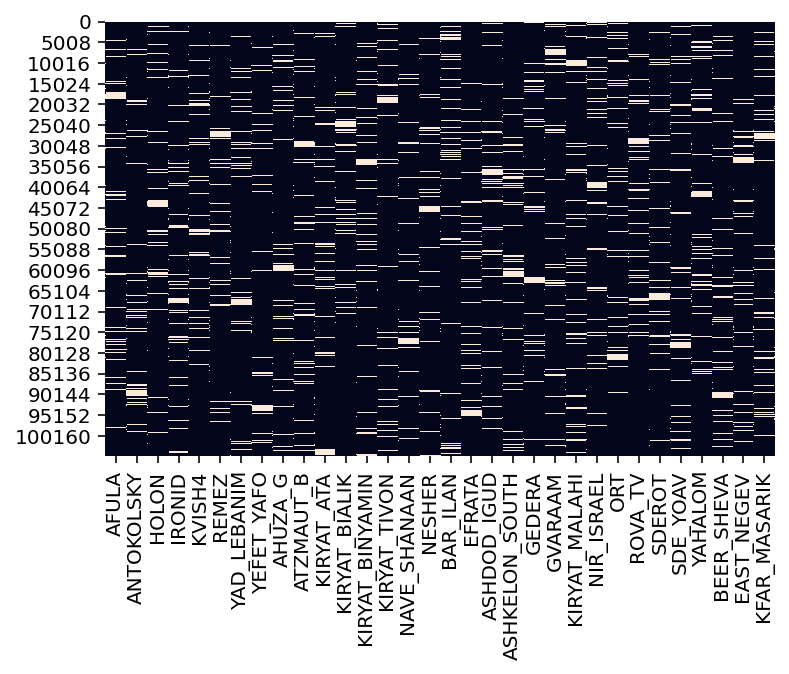

In [18]:
# plot the missing value chunks! see it is well distributed
X_missing = pd.DataFrame(np_X_missing,columns=r_PM25.columns)
y_missing = pd.DataFrame(np_y_missing,columns=r_PM25.columns)
sns.heatmap(y_missing.iloc[:,:32].notnull(), cbar=False);

### Some statistics

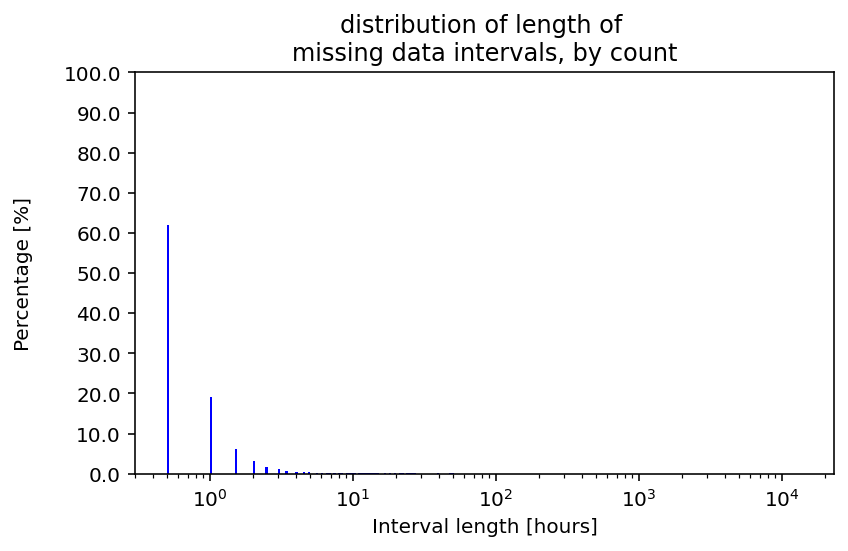

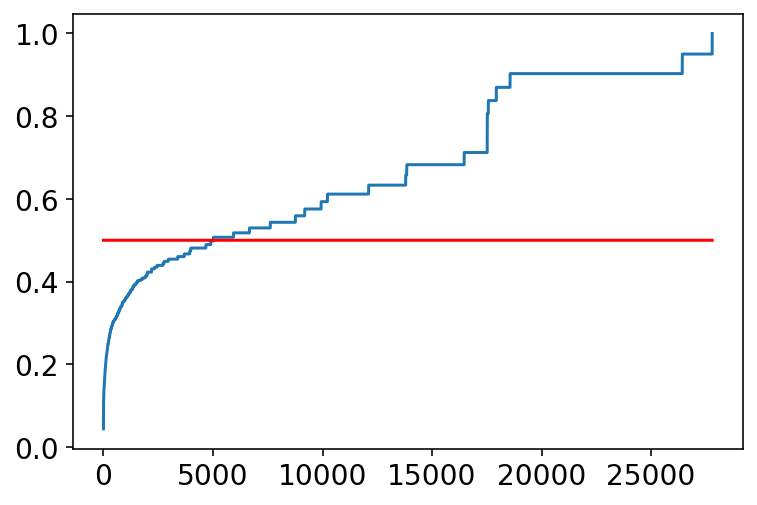

In [19]:
# (1) see what is the distribution of missing interval lengths (count wise and cummulative hours wise)?
missing_interval_lengths = get_nan_lengths(r_PM25.copy(),nanLengths=True)
# plot
plot_nan_lengths_dist(missing_interval_lengths)
plot_nan_lengths_cum_dist(missing_interval_lengths)

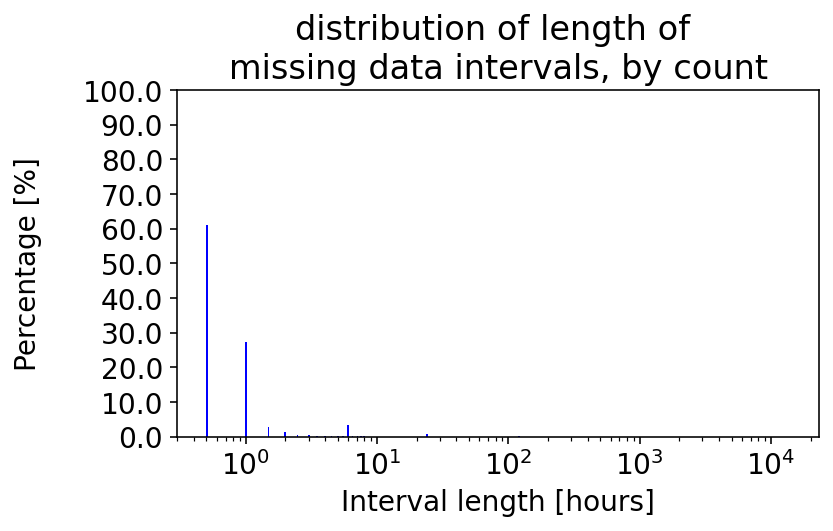

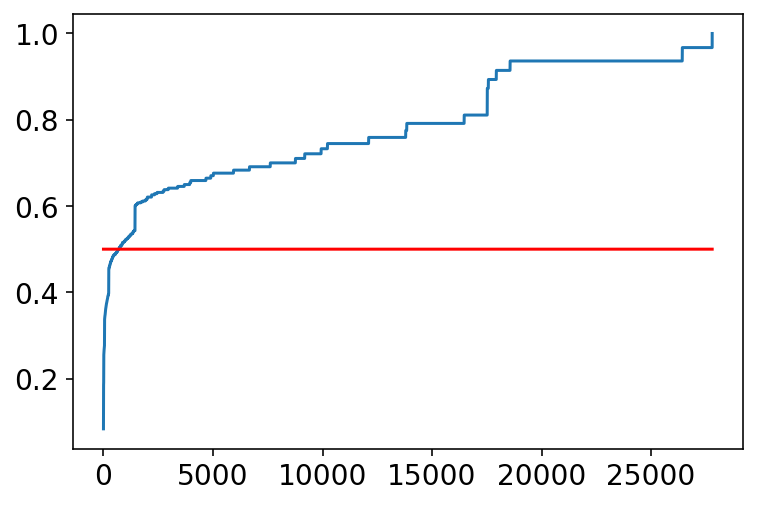

In [20]:
# am I keeping this distribution after extracting for validation?
missing_interval_lengths_X_missing = get_nan_lengths(X_missing.copy(),nanLengths=True)
# missing_interval_lengths_y_missing = get_nan_lengths(y_missing.copy(),nanLengths=False)
# plot
plot_nan_lengths_dist(missing_interval_lengths_X_missing)
plot_nan_lengths_cum_dist(missing_interval_lengths_X_missing)

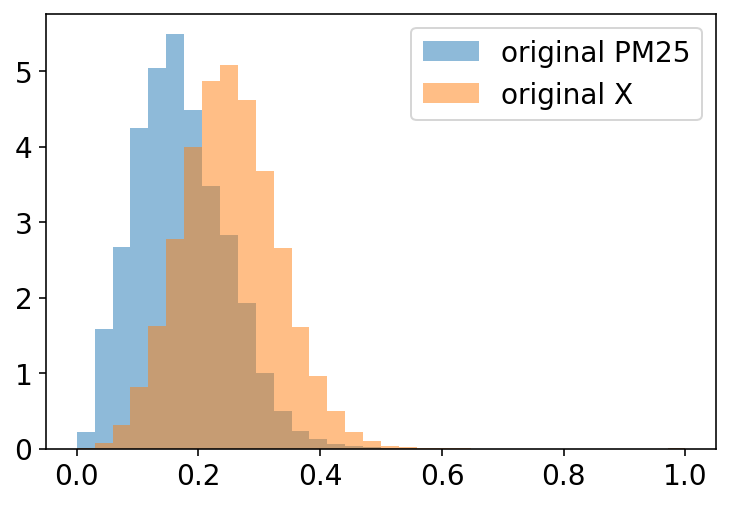

In [21]:
# (2) what is the distribution of each row (timestep) average missing values (out of 34 statiobs)?
# I cannot keep it of course... 
# plt.hist([r_PM25.isnull().sum(axis = 1)/r_PM25.shape[1],np.isnan(np_X_missing).sum(axis = 1)/np_X_missing.shape[1]],bins=50,label=['original PM25','original X','imputed'],density=True);

plt.hist(r_PM25.isnull().sum(axis = 1)/r_PM25.shape[1],bins=34,label=['original PM25'],density=True,alpha=0.5);
plt.hist(np.isnan(np_X_missing).sum(axis = 1)/np_X_missing.shape[1],bins=34,label=['original X'],density=True,alpha=0.5);

plt.legend();
plt.show();

In [22]:
# POSSIBLY - Remove rows where all is nan (5 like these)!!!

#### IterativeImputer Baysian Ridge

In [23]:
# First NORMALIZE ALL DATA!
# For some reason, it is not stable. possibly because I need to handle the non-positive values
# differently. maybe use MixMaxScaler transform:
# https://machinelearningmastery.com/power-transforms-with-scikit-learn/

# # option-1
# pt = PowerTransformer(method='box-cox')
# t_data = np_X_missing + 0.0000001
# pt.fit(t_data)

# # by default applies seperately to each column
# normal_data = pd.DataFrame(
#     pt.transform(t_data),
#     index=X_missing.index,
#     columns=X_missing.columns)

# # another option - 2
# scaler = MinMaxScaler(feature_range=(0.0000001, 10.0000001))
# power = PowerTransformer(method='box-cox')
# pipeline = Pipeline(steps=[('s', scaler),('p', power)])
# normal_data = pipeline.fit_transform(np_X_missing)

# normal_data = pd.DataFrame(
#     normal_data,
#     index=X_missing.index,
#     columns=X_missing.columns)

# another option - 3
normal_data = pd.DataFrame(
    np.log(np_X_missing+1),
    index=X_missing.index,
    columns=X_missing.columns)

In [24]:
# impute
num_iter = 1
imputed = impute_ii_BR(normal_data, num_iter)

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 36.0864164923739, scaled tolerance: 0.007437500787600639 
[IterativeImputer] Completing matrix with shape (105166, 34)


In [25]:
# # option-1
# inverse_imputed = pt.inverse_transform(imputed)-0.0000001

# # another option - 2
# inverse_imputed = pipeline.inverse_transform(imputed)

# another option - 3
inverse_imputed = np.exp(imputed)-1

In [26]:
# validate
results = validate(inverse_imputed, np_y_missing, np_r_PM25_y_mask, IL)

# # save 
# imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_ii_BR_"+str(IL[0])+'_'+str(num_iter))
# results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_ii_BR_"+str(IL[0])+'_'+str(num_iter))

In [27]:
results

,IL,RMSE,MedianAE,MeanAE,R2,MeanBias,MedianBias,NMB,NME
0,ALL,12.689152,3.862939,5.969249,0.703594,-1.801012,-0.749012,-0.087852,0.291176
1,720,9.776975,3.862172,5.655657,0.744887,-1.809858,-0.765596,-0.092288,0.288394
2,120,11.722588,3.842170,5.969227,0.721192,-1.513117,-0.662410,-0.071250,0.281081
3,24,12.802180,3.825372,6.010231,0.734635,-1.803090,-0.692538,-0.084422,0.281402
4,6,12.127660,3.869706,6.015040,0.726611,-1.923388,-0.825731,-0.093568,0.292615
5,1,15.022942,3.888677,6.064008,0.651508,-1.826066,-0.705764,-0.090883,0.301804
6,0.5,13.999180,3.887234,6.101052,0.665563,-1.928203,-0.837816,-0.095636,0.302605


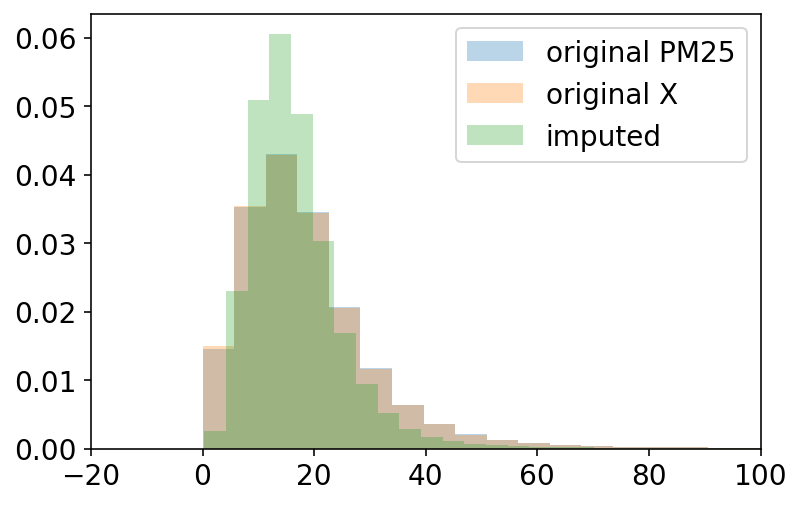

In [28]:
# look at the distribution of the imputed values vs. original
plot_hist(r_PM25.values, inverse_imputed, np_X_missing, density=True, no_bins=300,option='2')

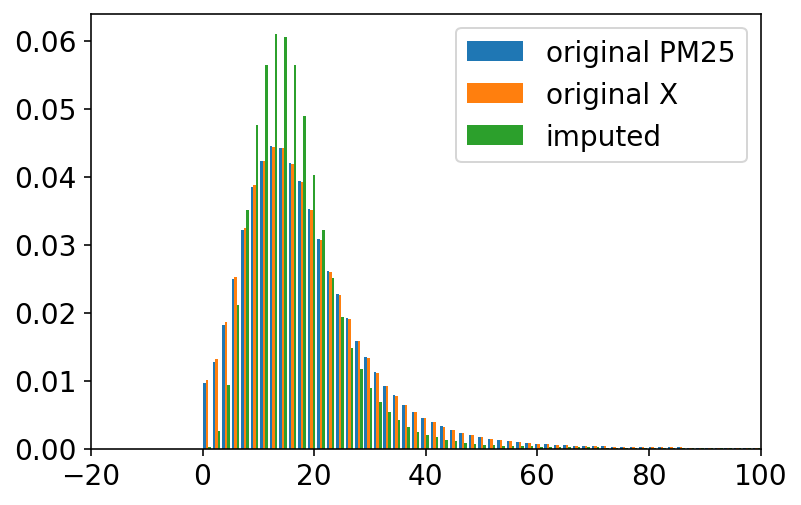

In [29]:
plot_hist(r_PM25.values, inverse_imputed, np_X_missing, density=True, no_bins=300,option='1')

In [ ]:
# change it to kdeplot (seaborn sns)

#### IterativeImputer Random Forest

In [35]:
# impute
num_iter = 1
num_trees = 10
rnd_state_forRF = 0
# max_features = ?
# min_samples_split = ?

 # !!!! notice I changed impute_ii_RF!!!!
params = {'bootstrap': 0,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10.0}

imputed = impute_ii_RF(np_X_missing, num_iter, rnd_state_forRF,params)
    
# validate
results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)

# # save 
# imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_ii_RF_"+str(IL[0])+'_'+str(num_iter))
# results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_ii_RF_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_trees))

[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 5941.564387521587, scaled tolerance: 1.6975 
[IterativeImputer] Completing matrix with shape (105166, 34)


In [36]:
results

,IL,RMSE,MedianAE,MeanAE,R2,MeanBias,MedianBias,NMB,NME
0,ALL,10.742218,4.03,5.857911,0.787573,0.187139,0.58,0.009129,0.285745
1,720,11.706467,4.08,5.867039,0.634257,0.355892,0.75,0.018148,0.299172
2,120,12.259775,4.04,6.141848,0.695054,0.521233,0.58,0.024544,0.289209
3,24,10.722463,4.06,5.980310,0.813849,-0.031273,0.56,-0.001464,0.280001
4,6,11.007439,4.07,5.931600,0.774784,0.127703,0.53,0.006212,0.288556
5,1,9.096906,3.99,5.641318,0.872218,0.101050,0.56,0.005029,0.280767
6,0.5,9.305569,3.94,5.590128,0.852227,0.049839,0.50,0.002472,0.277263


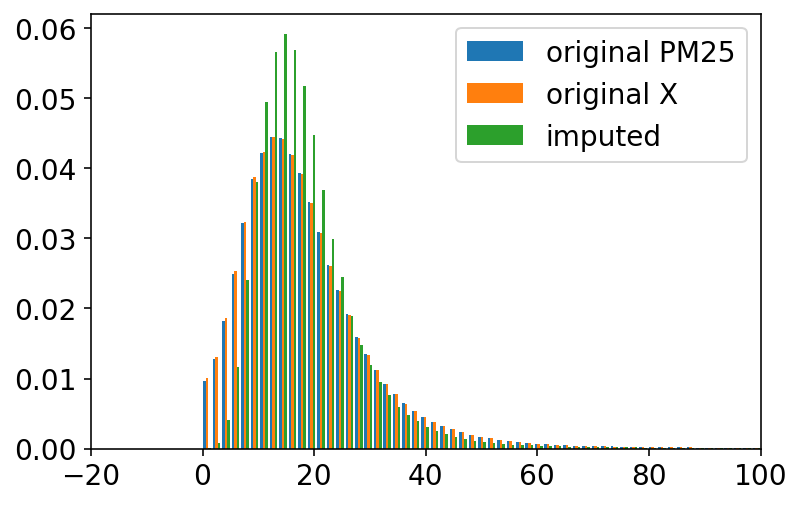

In [37]:
plot_hist(r_PM25.values, imputed, np_X_missing, density=True, no_bins=300,option='1')
# This might be problematic. it seems that it might be better to perform the imputation on 
# the raw data, as Yuval's fixes clearly generate non-normally distributed data. 

#### IterativeImputer KNN

In [ ]:
weight_type = 'distance' #'uniform','distance'
num_iter = 10
num_neighbors = 10

imputed = impute_ii_KNN(np_X_missing, num_iter, num_neighbors, weight_type)

# validate
results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)

# # save 
# imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_ii_KNN_"+str(IL[0])+'_'+str(num_iter))
# results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors))

In [ ]:
results

In [ ]:
plot_hist(r_PM25.values, imputed, np_X_missing, density=True, no_bins=300,option='1')

#### My KNN

In [32]:
num_neighbors = 9
imputed = impute_my_KNN(np_X_missing, num_neighbors)

# validate
results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)

# # save 
# imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
# imputed_df.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/imputed_my_KNN_"+str(IL[0])+'_'+str(num_iter))
# results.to_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_my_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors))

In [135]:
results

,RMSE,MedianAE,MeanAE,R2
0,20.424791,3.880241,6.900915,0.653475


In [ ]:
plot_hist(r_PM25.values, imputed, np_X_missing, density=True, no_bins=300,option='1')

# write a loop to perform it X times

In [115]:
# !!! add saving np_X_missing, np_y_missing, np_r_PM25_y_mask as well !!! that way will be 
# easy to add more methods if needed. 

In [70]:
np.random.seed(0) # if want to reproduce. will it make the two iterations identical?

In [114]:
num_repetitions = 5
IL = [720,120,24,6,1,0.5] # chunk sizes - 1 month, 5 days, 1 day, 6 hours, 1 hour, half hour
num_iter = 1 # try with one iteration for all, later it will be an array, each algorithm will 
# have its optimized number of iterations

for nr in range(num_repetitions):
    
    # generate validation
    np_X_missing, np_y_missing, np_r_PM25_y_mask = return_X_y(r_PM25,IL)
    
    #### IterativeImputer Baysian Ridge ####

    # First NORMALIZE ALL DATA!
    normal_data = pd.DataFrame(
        np.log(np_X_missing+1),
        index=X_missing.index,
        columns=X_missing.columns)
    # impute
    imputed = impute_ii_BR(normal_data, num_iter)
    inverse_imputed = np.exp(imputed)-1
    # validate
    results = validate(inverse_imputed, np_y_missing, np_r_PM25_y_mask, IL)
    # save 
    imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
    imputed_df.to_pickle("~/Documents/saved_data_from_notebooks/imputed_ii_BR_"+str(IL[0])+'_'+str(num_iter)+'_rep'+str(nr))
    results.to_pickle("~/Documents/saved_data_from_notebooks/results_ii_BR_"+str(IL[0])+'_'+str(num_iter)+'_rep'+str(nr))
    print(results)
    
    #### IterativeImputer Random Forest ####

    num_trees = 10 #hyperParam (although probably the more the better)
    rnd_state_forRF = 0
#     min_samples_split = ?
#     max_features = ?
    # impute
    
     # !!!! notice I changed impute_ii_RF!!!!
        
    imputed = impute_ii_RF(np_X_missing, num_iter, num_trees, rnd_state_forRF, min_samples_split, max_features)
    # validate
    results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)
    # save 
    imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
    imputed_df.to_pickle("~/Documents/saved_data_from_notebooks/imputed_ii_RF_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_trees)+'_rep'+str(nr))
    results.to_pickle("~/Documents/saved_data_from_notebooks/results_ii_RF_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_trees)+'_rep'+str(nr))
    print(results)
    
    #### IterativeImputer KNN ####

    weight_type = 'distance' #'uniform','distance' #hyperParam
    num_neighbors = 10 #hyperParam
    # impute
    imputed = impute_ii_KNN(np_X_missing, num_iter, num_neighbors, weight_type)
    # validate
    results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)
    # save 
    imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
    imputed_df.to_pickle("~/Documents/saved_data_from_notebooks/imputed_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
    results.to_pickle("~/Documents/saved_data_from_notebooks/results_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
    print(results)
    
    #### My KNN ####
    
    num_neighbors = 9
    # impute 
    imputed = impute_my_KNN(np_X_missing, num_neighbors)
    # validate
    results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)
    # save 
    imputed_df = pd.DataFrame(imputed, columns=r_PM25.columns) #turn it from IterativeImputer object to a dataframe
    imputed_df.to_pickle("~/Documents/saved_data_from_notebooks/imputed_my_KNN_"+str(IL[0])+'_'+str(num_iter)+'_rep'+str(nr))
    results.to_pickle("~/Documents/saved_data_from_notebooks/results_my_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
    print(results)

    


[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 32.88248149546708, scaled tolerance: 0.007437500787600639 
[IterativeImputer] Completing matrix with shape (105166, 34)
    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  12.438427  3.795164  5.833639  0.706097 -1.885671   -0.758914   
1  720  15.452101  3.423661  5.373319  0.603749 -1.625938   -0.258879   
2  120  10.826801  3.753620  5.630334  0.745553 -1.913110   -0.917705   
3   24  12.012421  3.937857  6.165726  0.790260 -1.996161   -1.013925   
4    6   9.454045  3.861531  5.689273  0.664802 -1.653497   -0.705309   
5    1  14.072941  3.899222  6.091390  0.677550 -2.108125   -0.867529   
6  0.5  11.841441  3.943961  6.052614  0.731271 -2.016629   -0.852553   

        NMB       NME  
0 -0.093228  0.288415  
1 -0.086354  0.285379  
2 -0.093315  0.274627  
3 -0.091141  0.281515  
4 -0.083498  0.287296  
5 -0.104327  0.301450  
6 -0.100171  0.300647  
[IterativeImpu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  11.122423  3.904759  5.722531  0.764998 -0.655609   -0.044383   
1  720  15.588694  3.769936  5.862712  0.596713 -0.769667    0.222102   
2  120   9.770506  4.102955  5.819453  0.792780 -0.671991   -0.209515   
3   24  11.651496  4.216342  6.326166  0.802675 -0.870753   -0.192775   
4    6   9.483836  4.068298  5.849988  0.662687 -0.442975    0.044001   
5    1  10.739499  3.767729  5.433054  0.812215 -0.633094   -0.099056   
6  0.5   7.937271  3.567556  5.053792  0.879261 -0.547009   -0.065438   

        NMB       NME  
0 -0.032413  0.282922  
1 -0.040877  0.311370  
2 -0.032777  0.283852  
3 -0.039757  0.288840  
4 -0.022369  0.295412  
5 -0.031330  0.268870  
6 -0.027171  0.251034  



[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 30.950137578472624, scaled tolerance: 0.007437500787600639 
[IterativeImputer] Completing matrix with shape (105166, 34)
    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  13.280805  3.865116  6.001375  0.713715 -1.907127   -0.758606   
1  720  13.003423  3.757138  5.915485  0.701520 -1.392577   -0.353833   
2  120  12.533740  3.798777  5.825099  0.730641 -2.005374   -0.915186   
3   24  12.987850  3.929911  6.233624  0.761085 -2.151900   -0.928727   
4    6  12.800380  3.855952  5.882463  0.735234 -1.821108   -0.779825   
5    1  15.199810  3.939245  6.119650  0.666672 -2.100499   -0.795796   
6  0.5  12.968641  3.916860  6.029220  0.680820 -1.972540   -0.798707   

        NMB       NME  
0 -0.092397  0.290756  
1 -0.068604  0.291419  
2 -0.094562  0.274678  
3 -0.099396  0.287931  
4 -0.089057  0.287667  
5 -0.103700  0.302122  
6 -0.098641  0.301504  
[IterativeImp

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  11.956590  3.939245  5.891818  0.767959 -0.639575   -0.049199   
1  720  12.006658  4.106762  6.244447  0.745525 -0.427444    0.124140   
2  120  12.647720  4.139178  6.201788  0.725720 -0.597148   -0.152534   
3   24  15.163851  4.186635  6.544506  0.674322 -1.081637   -0.238473   
4    6  12.242873  4.010136  5.920037  0.757795 -0.645320   -0.007097   
5    1   9.763603  3.721368  5.368086  0.862464 -0.579456   -0.035214   
6  0.5   8.905189  3.559226  5.082744  0.849501 -0.507493   -0.003503   

        NMB       NME  
0 -0.030986  0.285448  
1 -0.021058  0.307625  
2 -0.028158  0.292441  
3 -0.049961  0.302291  
4 -0.031558  0.289504  
5 -0.028607  0.265018  
6 -0.025378  0.254173  



[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 36.77019900336737, scaled tolerance: 0.007437500787600639 
[IterativeImputer] Completing matrix with shape (105166, 34)
    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  12.924621  3.806036  5.939713  0.742333 -1.913641   -0.822991   
1  720  13.537285  3.529028  5.700581  0.790454 -1.615006   -0.698522   
2  120  13.234147  3.705278  5.861921  0.752505 -1.712626   -0.853019   
3   24  11.290605  3.868151  5.984222  0.796862 -2.099887   -0.897957   
4    6  12.564239  3.883098  5.888280  0.696803 -1.984916   -0.851864   
5    1  13.214169  3.944943  6.089598  0.720890 -2.006515   -0.794895   
6  0.5  13.551266  3.924919  6.112601  0.655088 -2.062453   -0.842517   

        NMB       NME  
0 -0.092839  0.288163  
1 -0.077968  0.275207  
2 -0.081361  0.278479  
3 -0.097386  0.277529  
4 -0.098213  0.291350  
5 -0.100142  0.303923  
6 -0.102558  0.303958  
[IterativeImpu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  10.630051  3.892404  5.691737  0.782281 -0.651333   -0.086303   
1  720  11.712852  3.984363  5.874760  0.800554 -0.892420   -0.336416   
2  120  12.422003  3.985143  5.868459  0.709444 -0.472520    0.101200   
3   24   9.816800  4.073864  5.884326  0.711573 -0.756544   -0.136790   
4    6  11.513880  4.069788  6.076273  0.726611 -0.751277   -0.130306   
5    1   9.159928  3.733210  5.385542  0.835858 -0.547492   -0.004991   
6  0.5   8.610836  3.527276  5.069225  0.868165 -0.488094   -0.031470   

        NMB       NME  
0 -0.032110  0.280597  
1 -0.044254  0.291324  
2 -0.023446  0.291187  
3 -0.036954  0.287423  
4 -0.036304  0.293623  
5 -0.027360  0.269130  
6 -0.024149  0.250804  



[IterativeImputer] Completing matrix with shape (105166, 34)
[IterativeImputer] Change: 35.17786794237628, scaled tolerance: 0.007437500787600639 
[IterativeImputer] Completing matrix with shape (105166, 34)
    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL  11.529855  3.819413  5.792886  0.714510 -1.672678   -0.696926   
1  720   9.848912  3.581835  5.386335  0.705472 -1.115968   -0.380575   
2  120   9.633298  3.803609  5.565975  0.721383 -1.616454   -0.723621   
3   24  10.217606  3.893310  5.881345  0.722902 -1.911394   -0.870504   
4    6  12.043867  3.853018  5.908988  0.761299 -1.636237   -0.768891   
5    1  12.950126  3.912403  5.971016  0.734780 -1.888264   -0.728904   
6  0.5  13.797013  3.878793  6.043290  0.627418 -1.867322   -0.741284   

        NMB       NME  
0 -0.083048  0.287614  
1 -0.060054  0.289859  
2 -0.078423  0.270037  
3 -0.090152  0.277397  
4 -0.079813  0.288230  
5 -0.094181  0.297817  
6 -0.093806  0.303587  
[IterativeImpu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




    IL       RMSE  MedianAE    MeanAE        R2  MeanBias  MedianBias  \
0  ALL   9.878108  3.899319  5.684915  0.790449 -0.550040   -0.033119   
1  720   9.952006  3.981992  5.779505  0.699274 -0.030519    0.228203   
2  120  10.307068  4.145901  5.987954  0.681046 -0.846445   -0.109207   
3   24  10.019891  4.107921  6.084403  0.733522 -0.978340   -0.280793   
4    6  10.541334  3.982676  5.880812  0.817142 -0.548044   -0.080933   
5    1   8.988237  3.711316  5.311107  0.872236 -0.508030    0.013698   
6  0.5   9.380747  3.559596  5.070866  0.827763 -0.390843    0.013777   

        NMB       NME  
0 -0.027309  0.282254  
1 -0.001642  0.311017  
2 -0.041066  0.290509  
3 -0.046144  0.286974  
4 -0.026733  0.286856  
5 -0.025339  0.264903  
6 -0.019634  0.254737  


# display evaluation results per interval length size

In [116]:
num_repetitions = 5
IL = [720,120,24,6,1,0.5] 
num_iter = 1

In [187]:
results_df = pd.DataFrame()
for nr in range(num_repetitions):
    results_woD_BR = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_ii_BR_"+str(IL[0])+'_'+str(num_iter)+'_rep'+str(nr))
    results_woD_BR['algo'] = 'ii_BR'
    num_trees = 10
    results_woD_RF = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_ii_RF_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_trees)+'_rep'+str(nr))
    results_woD_RF['algo'] = 'ii_RF'
    num_neighbors = 10
    results_woD_KNN = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
    results_woD_KNN['algo'] = 'ii_KNN'
    num_neighbors = 9
    results_my_KNN = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_my_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
    results_my_KNN['algo'] = 'my_KNN'
    results_df = pd.concat([results_data , pd.concat([results_woD_BR,results_woD_RF,results_woD_KNN,results_my_KNN])])

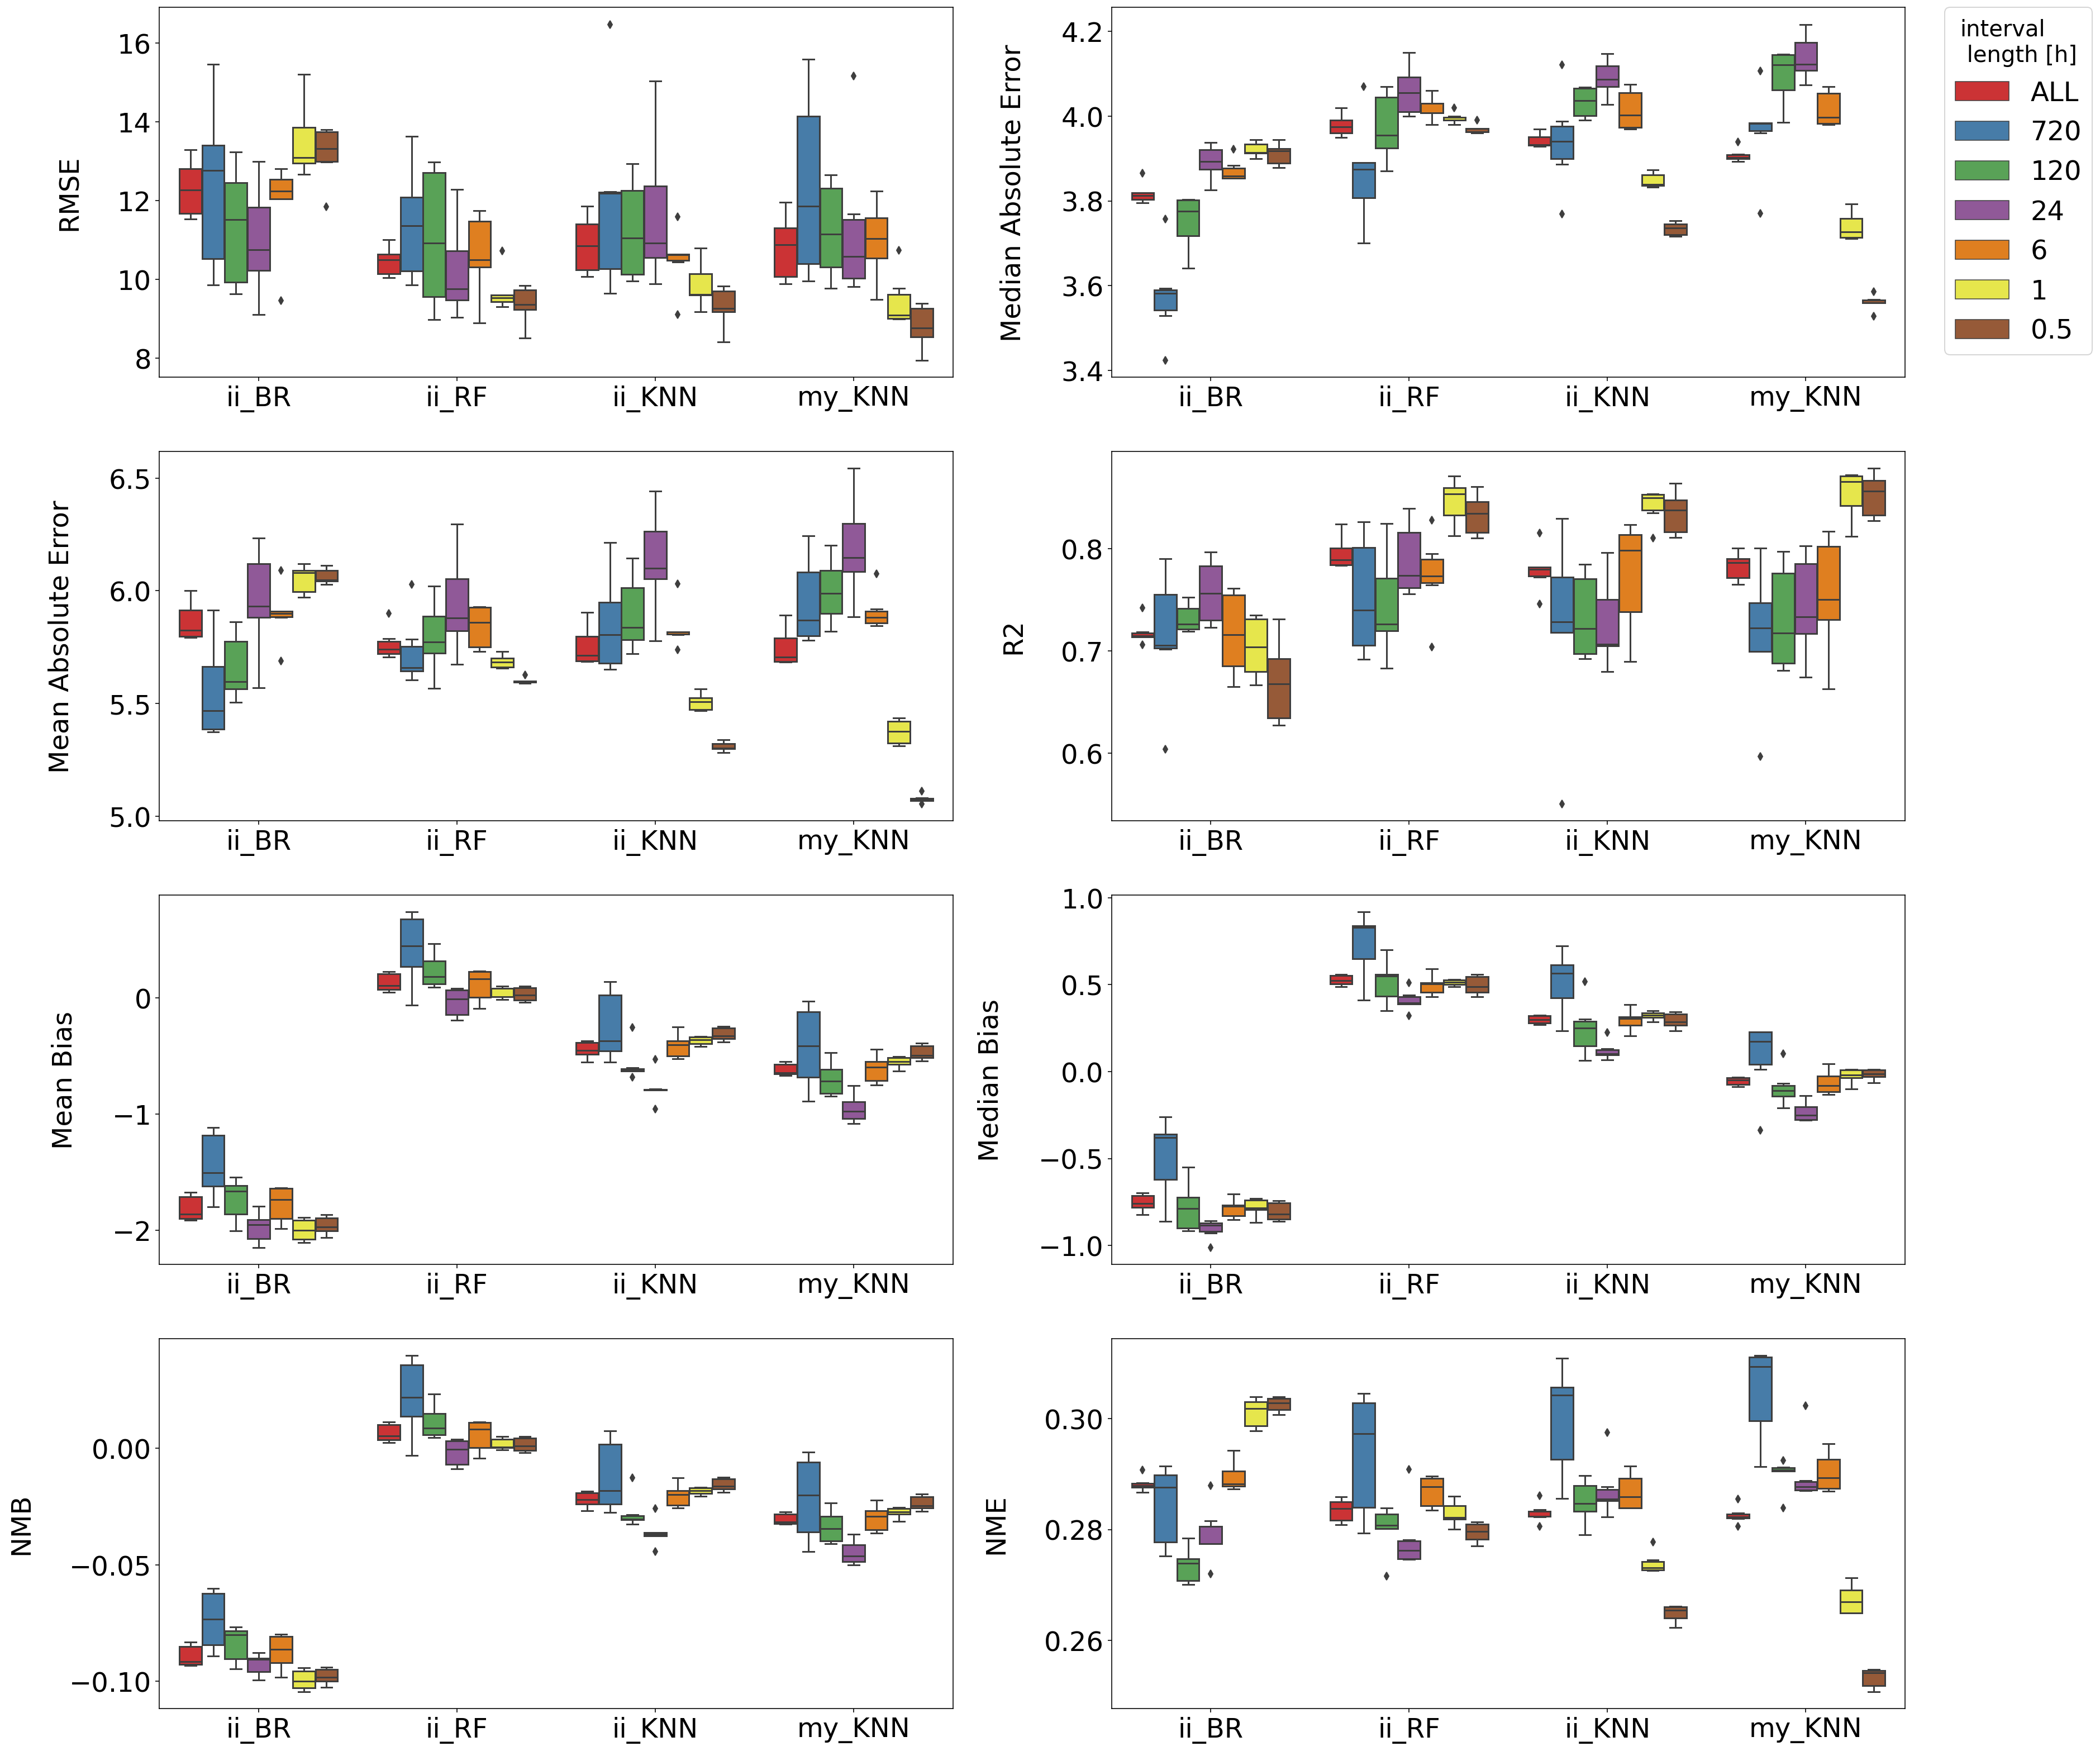

In [206]:
titles = ['RMSE','Median Absolute Error','Mean Absolute Error','R2','Mean Bias','Median Bias','NMB','NME']
columns =  results_df.columns[1:-1]

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2,figsize=(28,28))
# fig.suptitle('Repeated holdout results')
all_axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for i in range(len(titles)):
    sns.boxplot(x="algo", y=columns[i], hue="IL", data=results_df, palette="Set1",ax=all_axes[i]).set(
        xlabel='', 
        ylabel=titles[i]+'\n'
    )
    all_axes[i].get_legend().remove()
    
handles, labels = ax1.get_legend_handles_labels()
l = plt.legend(handles, labels, bbox_to_anchor=(1.05, 4.6), loc = 2, borderaxespad=0.,title = 'interval\n length [h]',title_fontsize=20)

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'lines.markersize': 24})

plt.tight_layout()
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/CV_results_basic.png", dpi=500)
plt.show();

In [ ]:
# I can also cut the performance further to hour of day or range of values (low, medium, high)

In [ ]:
# possibly - evaluate per range of values - can the model generate extreme values?
'''from Simon 2012: Low observed ozone concentrations occur much more frequently than high observed 
ozone concentrations, so metrics calculated over all observed values are dominated 
by performance at low concentrations'''

In [ ]:
# m (number of iterations) should be approximately as the average missing percentage. 
# which is about 15% in my case. ok to start with 5-10 though. 
# loose the 5 rows where all rows are empty!!!

In [4]:
# Ways to check randomness - https://www.theanalysisfactor.com/missing-data-mechanism/
# mark missing values in 1 and non-missing in zero. run a t-test or chi-square test 
# between one variable(column) and all other variables(columns). I think it should
# tell me if they are drown from the same poplutation (I want p-value not significant,
# meaning they are from different populations). if they come from the same population 
# I suspect that it is not random.
# MAYBE THE 0-1 IS TO TEST THE ORDER OF THE VALUES? IF IN RANDOM. = TEST FOR MCAR
# another option (I think test for MAR) is if I suspect that it is not completely random 
# (due to malfunctioning in a certain
# time maybe), I can try to train a logistic regression to see if time of day can 
# predict the missing non-missing classification. 

In [ ]:
# check the distribution of the imputed values Vs. the dist. of the non-missing values.

'''The idea is that good imputations have a distribution 
similar to the observed data. In other words, the imputations
could have been real values had they been observed. 
Except under MCAR, the distributions do not need to be identical, 
since strong MAR mechanisms may induce systematic differences between 
the two distributions. However, any dramatic differences between the 
imputed and observed data should certainly alert us to the possibility
that something is wrong.'''

In [ ]:
# https://stefvanbuuren.name/fimd/sec-nutshell.html
# http://www.stat.columbia.edu/~gelman/arm/missing.pdf

# TRY ALSO THE MICE FROM FANCYIMPUTE - IS IT THE SAME AS ITERTIVEIMPUTER?
# https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation


# MAYBE ADD missSVD?

In [ ]:
# notes to myself

# Go back one week ago...: 
# FIRST choose model parameters by CV:
# try different k of KNN, different number of trees in a forest and boosting/no-boosting
# or how deep is the forest. AND - number of iterations!!!

# SECOND, evaluate the 4-5 best models (possibly add SVD):
# (1) randomly choose for each station a group of X types of interval lengths
# (those that together form like 95% of the data) - in total, let it be about 10% of
# average number of non-nan indexes. 
# (2) make sure that the dist. of missing station data in all time-steps (i.e., rows)
# is approximately saved (maybe a statistical test?)
# (3) impute
# (4) compare the imputed values with the not-imputed ones. Are they drawn from the same population (maybe a statisticel test?)
# (5) repeat for 50-25 times (a repeated holdout method)
# (6) Evaluate per interval length

# Trash

In [ ]:
# for nr in range(num_repetitions):
#     results_woD_BR = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_ii_BR_"+str(IL[0])+'_'+str(num_iter)+'_rep'+str(nr))
#     num_trees = 10
#     results_woD_RF = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_ii_RF_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_trees)+'_rep'+str(nr))
#     num_neighbors = 10
#     results_woD_KNN = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_ii_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))
#     num_neighbors = 9
#     results_my_KNN = pd.read_pickle("~/Documents/saved_data_from_notebooks/results_my_KNN_"+str(IL[0])+'_'+str(num_iter)+'_'+str(num_neighbors)+'_rep'+str(nr))


# titles = ['RMSE','Median Absolute Error','Mean Absolute Error','R2','MeanBias','MedianBias','NMB','NME']

# fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2,figsize=(28,28))
# # fig.suptitle('Cross-validation results')

# N=7
# cmap = plt.cm.tab10
# col = cmap(np.linspace(0, 1, N))
# rcParams['axes.prop_cycle'] = cycler(color=col)

# ax1.plot(np.arange(0,4), [results_woD_BR.iloc[:,1],results_woD_RF.iloc[:,1],results_woD_KNN.iloc[:,1],results_my_KNN.iloc[:,1]],'*') #RMSE
# ax2.plot(np.arange(0,4), [results_woD_BR.iloc[:,2],results_woD_RF.iloc[:,2],results_woD_KNN.iloc[:,2],results_my_KNN.iloc[:,2]],'*') # Median Absolute Error
# ax3.plot(np.arange(0,4), [results_woD_BR.iloc[:,3],results_woD_RF.iloc[:,3],results_woD_KNN.iloc[:,3],results_my_KNN.iloc[:,3]],'*') # Mean Absolute Error
# ax4.plot(np.arange(0,4), [results_woD_BR.iloc[:,4],results_woD_RF.iloc[:,4],results_woD_KNN.iloc[:,4],results_my_KNN.iloc[:,4]],'*') #r2

# ax5.plot(np.arange(0,4), [results_woD_BR.iloc[:,5],results_woD_RF.iloc[:,5],results_woD_KNN.iloc[:,5],results_my_KNN.iloc[:,5]],'*') # MeanBias
# ax6.plot(np.arange(0,4), [results_woD_BR.iloc[:,6],results_woD_RF.iloc[:,6],results_woD_KNN.iloc[:,6],results_my_KNN.iloc[:,6]],'*') # MedianBias
# ax7.plot(np.arange(0,4), [results_woD_BR.iloc[:,7],results_woD_RF.iloc[:,7],results_woD_KNN.iloc[:,7],results_my_KNN.iloc[:,7]],'*') # NMB
# ax8.plot(np.arange(0,4), [results_woD_BR.iloc[:,8],results_woD_RF.iloc[:,8],results_woD_KNN.iloc[:,8],results_my_KNN.iloc[:,8]],'*') # NME

# legend_elements = [Line2D([0], [0], marker='*', color='w', label='ALL',
#                           markerfacecolor=col[0], markersize=20),
#                    Line2D([0], [0], marker='*', color='w', label='720',
#                           markerfacecolor=col[1], markersize=20),
#                    Line2D([0], [0], marker='*', color='w', label='120',
#                           markerfacecolor=col[2], markersize=20),
#                    Line2D([0], [0], marker='*', color='w', label='24',
#                           markerfacecolor=col[3], markersize=20),
#                    Line2D([0], [0], marker='*', color='w', label='6',
#                           markerfacecolor=col[4], markersize=20),
#                    Line2D([0], [0], marker='*', color='w', label='1',
#                           markerfacecolor=col[5], markersize=20),
#                    Line2D([0], [0], marker='*', color='w', label='0.5',
#                           markerfacecolor=col[6], markersize=20)]

# for i,ax in enumerate(fig.get_axes()):
#     ax.set_title(titles[i])   
#     ax.set_xticks(np.arange(0,4))

#     ax.set_xticklabels(['ii_BR','ii_RF','ii_KNN','my_KNN'],rotation=45)
# #     ax.set_xticklabels(['ii_BR','ii_RF','ii_KNN','my_KNN','ii_RF_add1','my_KNN_add1','ii_RF_add2','ii_RF_add1+2'],rotation=45)
#     ax.set_ylabel('$\mu g/m^3$\n')
#     if i==1:
#         ax.legend(handles=legend_elements,bbox_to_anchor=(1.32,1))
    
# plt.rcParams.update({'font.size': 24})
# plt.rcParams.update({'lines.markersize': 24})

# plt.tight_layout()
# # plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/CV_results_basic.png", dpi=500)
# # plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/CV_results_all.png", dpi=500)
# plt.show();

In [291]:
# def custom_cv_Kfolds(PM25,k):
    
#     kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
#     not_nan_idx = np.argwhere(PM25.notnull().values)
    
#     cv_splits = []
#     for train_index, test_index in kf.split(not_nan_idx):
#         cv_splits.append([train_index, test_index])
        
#     return cv_splits

# cv_splits = custom_cv_Kfolds(r_PM25,3)

# # Number of trees in random forest
# n_estimators = [int(x) for x in range(10,420,30)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt', 'log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# class MyClassifier(BaseEstimator, ClassifierMixin):
     
#     def __init__(self, lr=0.1):
#         # Some code
#         pass
    
#     def fit(self, X, y):
#         # Some code
#         pass

#     def predict(self, X):
#         # Some code
#         return X % 3


# scoring=my_func

# def my_scorer(y_true, y_predicted):
#     error = math.sqrt(np.mean((y_true - y_predicted)**2))
#     return error


# my_func = make_scorer(my_scorer, greater_is_better=False)

# gs = RandomizedSearchCV(MyClassifier(), param_distributions = random_grid, scoring = my_func, n_iter = 100, cv=cv_splits, random_state=42)

# x = np.arange(30)
# y = np.concatenate((np.zeros(10), np.ones(10), np.ones(10) * 2))
# gs.my_fit(x, y)

In [ ]:
#### fast KNN (with KDE) from impyute

#### I gave it like 20 hours and nothing happened... don't think this is working.

# # not sure what this is
# # sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# # impute 
# imputed=fast_knn(np_X_missing, k=10)

# # validate
# results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)

# results

#### MICE from impyute

# # maybe 5 rows of nans is not possible. 
# order = np.isnan(np_X_missing).sum(axis=1)
# idx = np.argwhere(order==34)

# np_X_missing_copy = np_X_missing.copy()
# np_X_missing_copy = np.delete(np_X_missing_copy,idx,axis=0)

# np_X_missing.shape
# np_X_missing_copy.shape

# imputed=mice(np_X_missing_copy)

# # validate
# results = validate(imputed, np_y_missing, np_r_PM25_y_mask, IL)

# results